In [1]:
import numpy as np
import pandas as pd
import sklearn 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
# ucitavanje podataka
X = pd.read_csv("../heart_disease_uci.csv")

In [3]:
X

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
X.thal.value_counts()

normal               196
reversable defect    192
fixed defect          46
Name: thal, dtype: int64

In [5]:
X=X.drop_duplicates()
X = X[X['dataset'] == 'Cleveland']
X.drop(('id'), axis=1, inplace=True)

In [6]:
print(X['ca'].isna().sum())

5


In [7]:
X = X.loc[X.restecg.notnull(), :]

In [8]:
X2=X.copy()
#inace sam dropo ca, thal i +slope+ 
#X2.drop(['ca', 'thal', 'slope'], axis=1, inplace=True)
X2.drop(['dataset'], axis=1, inplace=True)
X2.loc[X2.chol.isna(),'chol'] = X2.loc[:,'chol'].mean()
X2.loc[X2.trestbps.isna(),'trestbps'] = X2.loc[:,'trestbps'].mean()
X2.loc[X2.thalch.isna(),'thalch'] = X2.loc[:,'thalch'].mean()
X2.loc[X2.oldpeak.isna(),'oldpeak'] = X2.loc[:,'oldpeak'].mean()

X2 = X2.loc[X2.ca.notnull(), :]
X2 = X2.loc[X2.thal.notnull(), :]
X2 = X2.loc[X2.slope.notnull(), :]
X3 = X2.loc[X2.fbs.notnull(), :]
X4 = X3.loc[X3.exang.notnull(), :]

X5 = X4.copy()
# X5['oldpeak'] = X5['oldpeak'].abs()
X5 = X5[X5['oldpeak'] >= 0]
# X5['chol']=X5['chol'].replace(0,X5['chol'].mean())
# X5['trestbps']=X5['trestbps'].replace(0,X5['trestbps'].mean())
X5 = X5[(X5['chol'] != 0) & (X5['trestbps'] != 0)]
X5 = X5[(X5['chol'] >= 126) & (X5['chol'] <= 564)]

In [9]:
# X5.drop(('dataset'), axis=1, inplace=True)

## sad encoding kategorijskih varijabli

In [10]:
le = LabelEncoder()
le.fit(X.loc[:,'restecg'])
X5.loc[:,'restecg'] = le.transform(X5.loc[:,'restecg'])

le = LabelEncoder()
le.fit(X.loc[:,'exang'])
X5.loc[:,'exang'] = le.transform(X5.loc[:,'exang'])

le = LabelEncoder()
le.fit(X.loc[:,'fbs'])
X5.loc[:,'fbs'] = le.transform(X5.loc[:,'fbs'])

le = LabelEncoder()
le.fit(X.loc[:,'cp'])
X5.loc[:,'cp'] = le.transform(X5.loc[:,'cp'])

le = LabelEncoder()
le.fit(X.loc[:,'ca'])
X5.loc[:,'ca'] = le.transform(X5.loc[:,'ca'])

le = LabelEncoder()
le.fit(X.loc[:,'thal'])
X5.loc[:,'thal'] = le.transform(X5.loc[:,'thal'])

le = LabelEncoder()
le.fit(X.loc[:,'slope'])
X5.loc[:,'slope'] = le.transform(X5.loc[:,'slope'])
# X5 = pd.get_dummies(X5, columns=['sex'], prefix='sex', drop_first=True)
# X5 = pd.get_dummies(X5, columns=['restecg'], prefix='restecg', drop_first=True)
# X5 = pd.get_dummies(X5, columns=['exang'], prefix='exang', drop_first=True)
# X5 = pd.get_dummies(X5, columns=['fbs'], prefix='fbs', drop_first=True)
# X5 = pd.get_dummies(X5, columns=['cp'], prefix='cp', drop_first=True)

#one hot 
X5 = pd.get_dummies(X5, columns=['sex'], prefix='sex', drop_first=False)

# X5 = pd.get_dummies(X5, columns=['dataset'], prefix='dataset', drop_first=False)

/var/folders/gz/blq0wwnn6bg59fmygpb2zpp80000gn/T/ipykernel_46053/359611030.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X5.loc[:,'restecg'] = le.transform(X5.loc[:,'restecg'])
/var/folders/gz/blq0wwnn6bg59fmygpb2zpp80000gn/T/ipykernel_46053/359611030.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X5.loc[:,'exang'] = le.transform(X5.loc[:,'exang'])
/var/folders/gz/blq0wwnn6bg59fmygpb2zpp80000gn/T/ipykernel_46053/359611030.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inpl

In [11]:
X=X5.copy()
y=X['num'].values
X=X.drop(labels=['num'], axis=1)
X

,age,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,sex_Female,sex_Male
0,63,3,145.0,233.0,1,0,150.0,0,2.3,0,0,0,0,1
1,67,0,160.0,286.0,0,0,108.0,1,1.5,1,3,1,0,1
2,67,0,120.0,229.0,0,0,129.0,1,2.6,1,2,2,0,1
3,37,2,130.0,250.0,0,1,187.0,0,3.5,0,0,1,0,1
4,41,1,130.0,204.0,0,0,172.0,0,1.4,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,140.0,241.0,0,1,123.0,1,0.2,1,0,2,1,0
298,45,3,110.0,264.0,0,1,132.0,0,1.2,1,0,2,0,1
299,68,0,144.0,193.0,1,1,141.0,0,3.4,1,2,2,0,1
300,57,0,130.0,131.0,0,1,115.0,1,1.2,1,1,2,0,1


In [12]:
for index,v in enumerate(y):
    if v > 1:
        y[index] = 1

In [13]:
# print(X)
# X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)
# print(X_resampled)
# print(len(y_resampled))

#nes skroz drugo od SMOTE-a
# data = pd.concat([X, y], axis=1)

# Function to perform random sampling with replacement
def random_sampling_with_replacement(data, num_samples):
    sampled_data = data.sample(n=num_samples, replace=True, random_state=42)
    return sampled_data

# Set the desired number of new samples
num_new_samples = 600

# Generate new samples using random sampling with replacement
expanded_data = random_sampling_with_replacement(X5, num_new_samples)

# Separate the features and labels
X = expanded_data.drop('num', axis=1)  # Replace 'target_column_name' with your actual target column
y = expanded_data['num']
y[y > 1] = 1
print(len(y))
print(y)
print(X)

600
103    0
274    1
107    1
71     1
190    0
      ..
293    1
64     1
146    1
226    0
241    0
Name: num, Length: 600, dtype: int64
     age  cp  trestbps   chol  fbs  restecg  thalch  exang  oldpeak  slope  \
103   71   2     110.0  265.0    1        0   130.0      0      0.0      2   
274   59   3     134.0  204.0    0        1   162.0      0      0.8      2   
107   57   2     128.0  229.0    0        0   150.0      0      0.4      1   
71    67   0     125.0  254.0    1        1   163.0      0      0.2      1   
190   50   2     129.0  196.0    0        1   163.0      0      0.0      2   
..   ...  ..       ...    ...  ...      ...     ...    ...      ...    ...   
293   63   0     140.0  187.0    0        0   144.0      1      4.0      2   
64    54   0     120.0  188.0    0        1   113.0      0      1.4      1   
146   57   0     165.0  289.0    1        0   124.0      0      1.0      1   
226   47   0     112.0  204.0    0        1   143.0      0      0.1      2   
24

/var/folders/gz/blq0wwnn6bg59fmygpb2zpp80000gn/T/ipykernel_46053/2845578489.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y > 1] = 1


# Treniranje modela

GaussianNB - Best Parameters: {'classifier__var_smoothing': 0.1}
GaussianNB - Average Accuracy: 0.8317
GaussianNB - Average Recall: 0.7411
GaussianNB - Average Precision: 0.8395
GaussianNB - Average Confusion Matrix:
[[31.3  3.6]
 [ 6.5 18.6]]
GaussianNB - Average ROC-AUC: 0.819


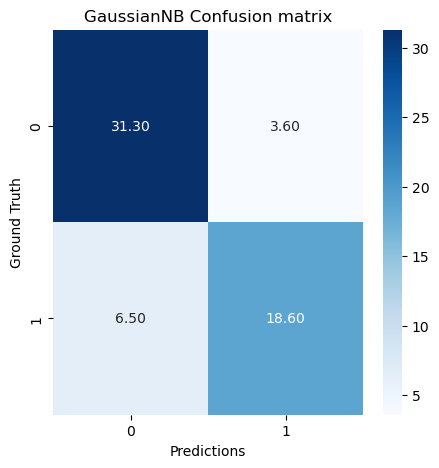

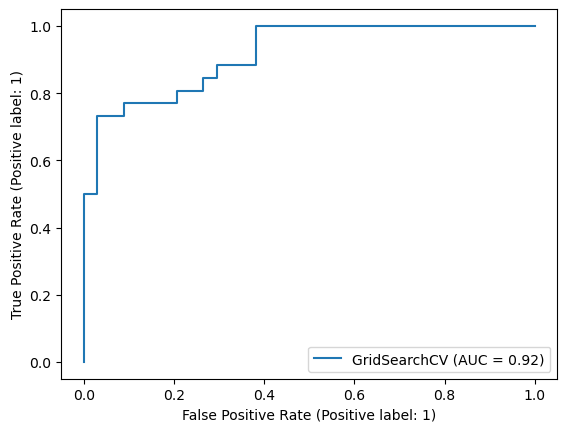

RandomForestClassifier - Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'classifier__random_state': 42}
RandomForestClassifier - Average Accuracy: 0.9717
RandomForestClassifier - Average Recall: 0.956
RandomForestClassifier - Average Precision: 0.9753
RandomForestClassifier - Average Confusion Matrix:
[[34.3  0.6]
 [ 1.1 24. ]]
RandomForestClassifier - Average ROC-AUC: 0.9694


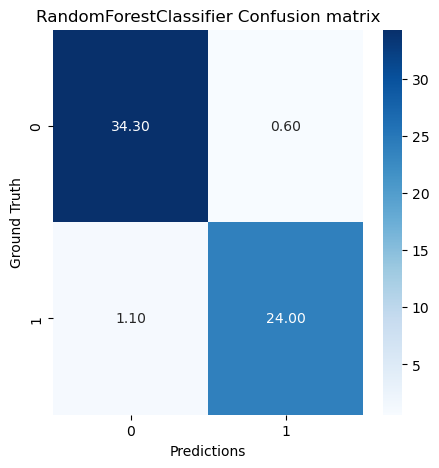

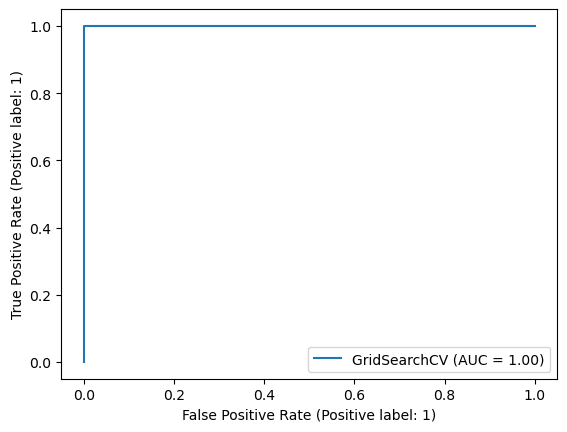

SVC - Best Parameters: {'classifier__C': 100, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly', 'classifier__random_state': 42, 'classifier__tol': 1e-10}
SVC - Average Accuracy: 0.9583
SVC - Average Recall: 0.9402
SVC - Average Precision: 0.9593
SVC - Average Confusion Matrix:
[[33.9  1. ]
 [ 1.5 23.6]]
SVC - Average ROC-AUC: 0.9558


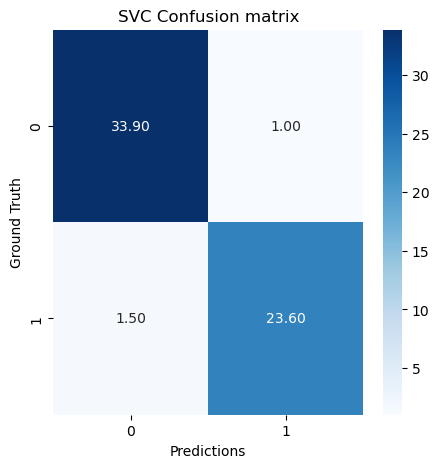

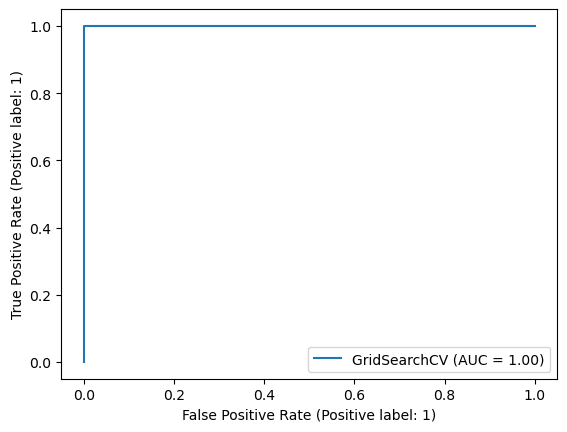

LogisticRegression - Best Parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__random_state': 42, 'classifier__solver': 'lbfgs', 'classifier__tol': 1e-10}
LogisticRegression - Average Accuracy: 0.8617
LogisticRegression - Average Recall: 0.7648
LogisticRegression - Average Precision: 0.8923
LogisticRegression - Average Confusion Matrix:
[[32.5  2.4]
 [ 5.9 19.2]]
LogisticRegression - Average ROC-AUC: 0.848


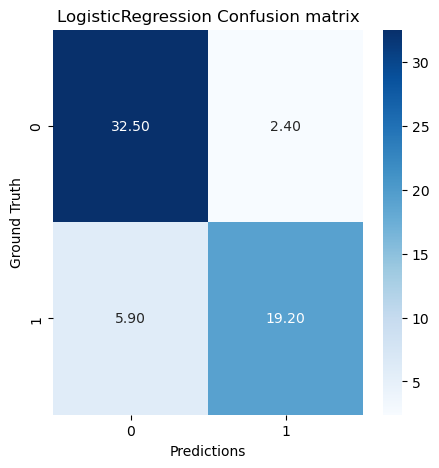

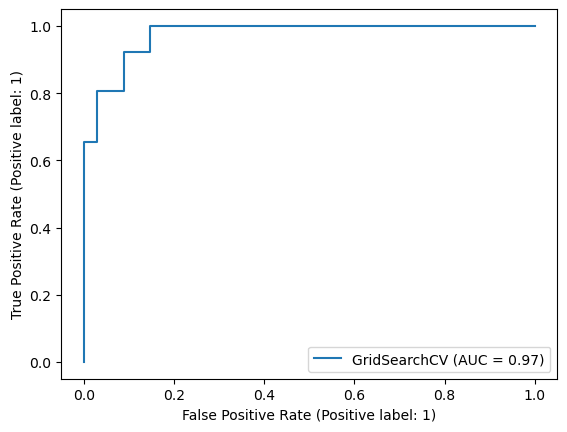

DecisionTreeClassifier - Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__random_state': 42, 'classifier__splitter': 'best'}
DecisionTreeClassifier - Average Accuracy: 0.96
DecisionTreeClassifier - Average Recall: 0.9322
DecisionTreeClassifier - Average Precision: 0.9716
DecisionTreeClassifier - Average Confusion Matrix:
[[34.2  0.7]
 [ 1.7 23.4]]
DecisionTreeClassifier - Average ROC-AUC: 0.9561


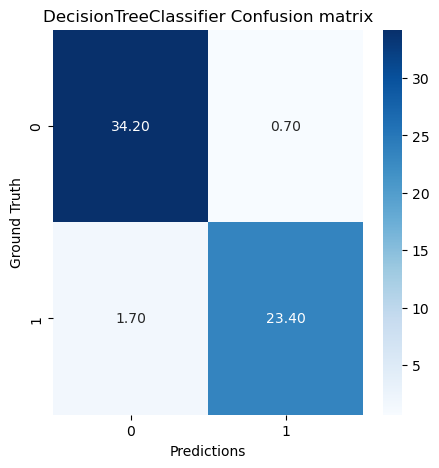

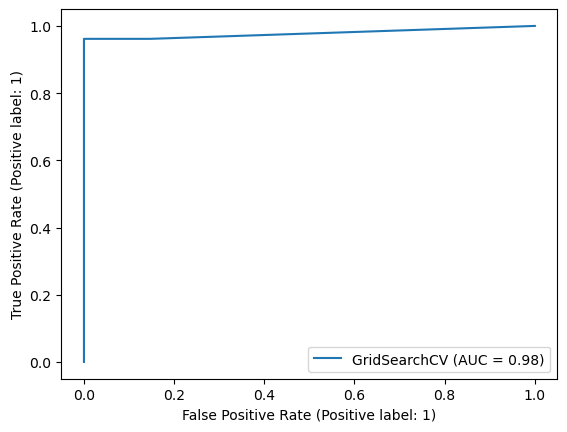

In [14]:
from sklearn import svm
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt


num_folds=10
kf = StratifiedKFold(n_splits=num_folds, random_state=42, shuffle=True)
X_np = X.to_numpy()
y=y.to_numpy()

nb = Pipeline([('scaler', MinMaxScaler()), ('classifier', GaussianNB())])
rf = Pipeline([('scaler', MinMaxScaler()), ('classifier', RandomForestClassifier())])
svm = Pipeline([('scaler', MinMaxScaler()), ('classifier', SVC())])
lr = Pipeline([('scaler', MinMaxScaler()), ('classifier', LogisticRegression())])
dt = Pipeline([('scaler', MinMaxScaler()), ('classifier', DecisionTreeClassifier())])

classifiers = [nb, rf, svm, lr, dt]

for classifier in classifiers:
    total_accuracy = 0
    total_recall = 0
    total_precision = 0
    total_confusion_matrix = np.zeros((2, 2))  # Assuming binary classification
    total_roc_auc = 0

    # Define parameter grid for grid search
    param_grid = {}

    if classifier == nb:
        param_grid = {'classifier__var_smoothing': [1e-20, 1e-12, 1e-10, 1e-9, 1e-8, 1e-7,1e-5,1e-1,1, 10, 100]}
    elif classifier == rf:
        param_grid = {'classifier__n_estimators': [50, 100, 200],
                      'classifier__max_depth': [None, 10, 20],
                      'classifier__min_samples_split': [2, 5, 10],
                      'classifier__random_state': [42]}
    elif classifier == svm:
        param_grid = {'classifier__C': [1e-4,1e-2,1e-1,1,10,50,100],
                      'classifier__kernel': ['linear', 'rbf', 'poly'],
                      'classifier__gamma': ['scale', 'auto'],
                      'classifier__tol': [1e-10, 1e-9, 1e-6, 1e-4, 0.001, 0.01],
                      'classifier__random_state': [42]}
    elif classifier == lr:
        param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 500],
                      'classifier__tol': [1e-10, 1e-9, 1e-6, 1e-4, 0.001, 0.01],
                      'classifier__penalty': ['l2'],
                      'classifier__solver': ['lbfgs', 'liblinear', 'newton-cholesky'],
                      'classifier__random_state': [42]}
    elif classifier == dt:
        param_grid = {'classifier__max_depth': [None, 5, 10, 20, 25, 30, 40, 100],
                      'classifier__min_samples_split': [2, 5, 10, 15, 20, 30],
                      'classifier__min_samples_leaf': [1, 2, 3, 4, 6, 8],
                      'classifier__splitter': ['best', 'random'],
                      'classifier__criterion': ['gini', 'entropy', 'log_loss'],
                      'classifier__random_state': [42]}

    # Perform K-Fold cross-validation with grid search
    grid_search = GridSearchCV(classifier, param_grid, cv=kf)
    
    for train_index, test_index in kf.split(X_np, y):
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Perform grid search on the training data
        grid_search.fit(X_train, y_train)

        # Use the best model to make predictions on the test set
        y_pred = grid_search.best_estimator_.predict(X_test)
        
        # Evaluate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        total_accuracy += accuracy
        
        # Evaluate recall and precision
        report = classification_report(y_test, y_pred, output_dict=True)
        total_recall += report['1']['recall']
        total_precision += report['1']['precision']

        # Confusion matrix
        total_confusion_matrix += confusion_matrix(y_test, y_pred)
        
        # ROC-AUC
        roc_auc = roc_auc_score(y_test, y_pred)
        total_roc_auc += roc_auc
        
    # Calculate average accuracy across folds
    avg_accuracy = round(total_accuracy / num_folds, 4)
    avg_recall = round(total_recall / num_folds, 4)
    avg_precision = round(total_precision / num_folds, 4)
    avg_confusion_matrix = np.around(total_confusion_matrix / num_folds, decimals=4)
    avg_roc_auc = round(total_roc_auc / num_folds, 4)
    
    # Print the results for each classifier
    print(f"{classifier['classifier'].__class__.__name__} - Best Parameters: {grid_search.best_params_}")
    print(f"{classifier['classifier'].__class__.__name__} - Average Accuracy: {avg_accuracy}")
    print(f"{classifier['classifier'].__class__.__name__} - Average Recall: {avg_recall}")
    print(f"{classifier['classifier'].__class__.__name__} - Average Precision: {avg_precision}")
    print(f"{classifier['classifier'].__class__.__name__} - Average Confusion Matrix:\n{avg_confusion_matrix}")
    print(f"{classifier['classifier'].__class__.__name__} - Average ROC-AUC: {avg_roc_auc}")
    
    # Plot Confusion Matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(avg_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predictions')
    plt.ylabel('Ground Truth')
    plt.title(f"{classifier['classifier'].__class__.__name__} Confusion matrix")
    plt.show()
    
    RocCurveDisplay.from_estimator(grid_search, X_test, y_test)
    plt.show()